## Library

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import operator
import math
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from tqdm import tqdm
from numba import jit, njit
import cupy as cp

### Reading Data
Delete ['Remove']

In [2]:
# Read Data
# Select part to show, because the dataset is too large and cost to much time to have the result
# Will upload result from whole dataset later
during = pd.read_csv('D:/Python/GA/during_comments_clean.csv')
post = pd.read_csv('D:/Python/GA/post_comments_clean.csv')
pre = pd.read_csv('D:/Python/GA/pre_comments_clean.csv')

In [3]:
during.shape

(6401104, 10)

In [4]:
# There are a lot of ['Remove'] in dataset. 
# They are posts that content has been deleted, so we remove them here.
'''def remove(dataframe, feature = 'body'):
    df = dataframe[dataframe[feature] != "['remove']"]
    df.reset_index(inplace=True)
    df.drop(['index', 'Unnamed: 0'], axis=1, inplace = True)
    
    return df'''

'def remove(dataframe, feature = \'body\'):\n    df = dataframe[dataframe[feature] != "[\'remove\']"]\n    df.reset_index(inplace=True)\n    df.drop([\'index\', \'Unnamed: 0\'], axis=1, inplace = True)\n    \n    return df'

In [5]:
# There are a lot of ['Remove'] in dataset. 
# They are posts that content has been deleted, so we remove them here.
def remove(dataframe, feature = 'body'):
    tqdm.pandas(desc = 'Progress: ')
    dataframe[feature] = dataframe[feature].progress_apply(lambda x: x.strip("[]',"))
    dataframe[feature] = dataframe[feature].progress_apply(lambda x: x.split("', '"))

    
    bl = []
    for x in dataframe[feature]:
        bl.append('remove' not in x) 
    bl = pd.Series(bl)
    df = dataframe[bl == True]
    
    df.reset_index(inplace=True)
    df.drop(['index'], axis=1, inplace = True)
    
    return df

In [6]:
# Apply to three stages
during = remove(during)
post = remove(post)
pre = remove(pre)

Progress: 100%|██████████| 6401104/6401104 [00:11<00:00, 541304.60it/s] 
C:\Users\Administrator\AppData\Local\Temp\ipykernel_7512\808002404.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['index'], axis=1, inplace = True)
Progress: 100%|██████████| 2680006/2680006 [00:07<00:00, 380452.89it/s] 
C:\Users\Administrator\AppData\Local\Temp\ipykernel_7512\808002404.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['index'], axis=1, inplace = True)
Progress: 100%|██████████| 1873465/1873465 [00:05<00:00, 361890.34it/s] 
C:\Users\Administrator\AppData\Local\Temp\ipykernel_7512\808002404.py:16: Setting

In [7]:
pre

,Unnamed: 0,author_fullname,body,created_utc,distinguished,id,is_submitter,link_id,parent_id,score
0,0,t2_34czceux,"[username, definitely, check]",2021-01-23 23:59:59,NaN,gkgv09b,False,t3_l2wx2p,t1_gkgp332,1
1,1,t2_4r39phh,"[/you/deepfuckingvalue, real, world, bobby, fu...",2021-01-23 23:59:59,NaN,gkgv08b,False,t3_l3j3t8,t3_l3j3t8,3
2,2,t2_5lvt8cv0,"[depends, bad, want, share, almost, atm, put, ...",2021-01-23 23:59:57,NaN,gkgv01l,False,t3_l2wx2p,t1_gkgtso3,1
3,3,t2_u6ahvy9,"[congrats, hop, someday, soon]",2021-01-23 23:59:57,NaN,gkgv01c,False,t3_l3aj4z,t3_l3aj4z,1
4,4,t2_rmodmm0,"[know, hold, people, back, life, fear, hear, p...",2021-01-23 23:59:56,NaN,gkgv002,False,t3_l3igst,t3_l3igst,1
...,...,...,...,...,...,...,...,...,...,...
1805924,1873460,t2_lb8ec,"[probably, murder, basement, grindr, date]",2021-01-03 05:00:19,NaN,ghwhm12,False,t3_koiz6w,t1_ghwhenc,5
1805925,1873461,t2_39tdob5l,"[fed, start, pump, repo, market, collapse, rig...",2021-01-03 05:00:16,NaN,ghwhlvr,False,t3_kp0tcw,t1_ghvj28g,1
1805926,1873462,t2_91fl24x3,"[actually, fund]",2021-01-03 05:00:16,NaN,ghwhlvm,True,t3_kpe1wu,t1_ghwh9du,1
1805927,1873463,t2_8sov86qd,"[many, squirrel, must, die, look, fly]",2021-01-03 05:00:09,NaN,ghwhlgm,False,t3_koiz6w,t1_ghwhg1d,2


In [8]:
# Count word frequency
def count_word_frequency(words):
    w_frequency = dict()
    for word in tqdm(words, desc = 'TF Counting Progress: '):
        if word not in w_frequency.keys():
            w_frequency[word] = words.count(word)
    sorted_d = dict(sorted(w_frequency.items(), key=operator.itemgetter(1),reverse=True))
    return sorted_d

In [9]:
def total_terms(sentences):
    words = []
    
    # Apply Function to count Terms Frequencies
    for i in sentences:
        words += i
    tf = count_word_frequency(words)
    
    idfcount = dict()
    
    # Count IDF
    for row in tqdm(sentences, desc = 'IDF Counting Progress: '):
        temp = []
        for w in row:
            if w not in temp:
                temp.append(w)
                if w in idfcount:
                    idfcount[w] += 1
                else:
                    idfcount[w] = 1

    sortedtf = dict(sorted(tf.items(), key=operator.itemgetter(1),reverse=True))
    sortedidf = dict(sorted(idfcount.items(), key=operator.itemgetter(1),reverse=True))

    idfValues = dict()
    
    # Calculate IDF Values
    for key in tqdm(sortedtf.keys(), desc = 'IDF Value Calculating Progress: '):
        idfValues[key] = math.log10(len(sentences)/idfcount[key])
    
    # Calculate TF-IDF Values
    tfidfValues = dict()
    for key in tqdm(sortedtf.keys(), desc = 'TF-IDF Value Progress: '):
        tfidfValues[key] = idfValues[key] * tf[key]
    sortedtfidf = dict(sorted(tfidfValues.items(), key=operator.itemgetter(1),reverse=True))

    return sortedtf, idfValues, sortedtfidf

In [10]:
# Show Table of TF, IDF, TF-IDF
def show_num_terms(dicts, sortby, complete = False):
    columnnames = ['TF','IDF','TF-IDF']
    summary = []
    for key in dicts[0].keys():
        summary.append([dicts[0][key], dicts[1][key], dicts[2][key]])
    df = pd.DataFrame(summary,index = dicts[0].keys(), columns = columnnames)
    if(complete):
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):
            display(df.sort_values(by=columnnames[sortby], ascending=False))
    else:
        display(df.sort_values(by=columnnames[sortby], ascending=False))

In [11]:
# Create WordCloud
def show_wordcloud(sentences, save=False, img_name=None):
  wordcloud = WordCloud(
    background_color = 'white',
    max_words = 1000,
    relative_scaling = 1,
    scale = 3,
    random_state=1,
    collocations=False
  ).generate_from_frequencies(sentences)
  fig = plt.figure(1, figsize=(12, 12))
  plt.axis('off')
  plt.imshow(wordcloud)
  if save: plt.savefig(img_name)
  plt.show()

In [12]:
# During stage
d_tff, d_idff, d_tfidf = total_terms(during.body)

TF-IDF Value Progress: 100%|██████████| 598832/598832 [00:00<00:00, 1156867.12it/s]


In [13]:
# Post Stage
post_tff, post_idff, post_tfidf = total_terms(post.body)

TF-IDF Value Progress: 100%|██████████| 377965/377965 [00:00<00:00, 1555412.85it/s]


In [14]:
# Pre Stage
pre_tff, pre_idff, pre_tfidf = total_terms(pre.body)

TF-IDF Value Progress: 100%|██████████| 315155/315155 [00:00<00:00, 1800888.66it/s]


In [15]:
# TF-IDF During Stage
show_num_terms([d_tff,d_idff,d_tfidf],0)

,TF,IDF,TF-IDF
buy,608367,0.912277,554998.940012
hold,465527,1.032531,480671.172314
go,452958,1.026688,465046.364715
gme,437250,1.029176,450007.236121
get,410877,1.057662,434569.126742
...,...,...,...
"guru', ""''"", '``",1,6.611417,6.611417
"guy', ""''"", 'bunch",1,6.611417,6.611417
1.260.000.000,1,6.611417,6.611417
"wrong', ""'hands"", '💎👐",1,6.611417,6.611417


In [16]:
# TF-IDF Post Stage
show_num_terms([post_tff, post_idff, post_tfidf],0)

,TF,IDF,TF-IDF
go,253478,1.006465,255116.800654
buy,218072,1.081728,235894.691842
get,213035,1.067100,227329.693992
like,177288,1.141411,202358.449231
gme,142788,1.268781,181166.738007
...,...,...,...
broke-tard,1,6.345360,6.345360
"robinhood', ""'s"", 'success",1,6.345360,6.345360
🤑💰💵,1,6.345360,6.345360
feb3-4,1,6.345360,6.345360


In [17]:
# TF-IDF Pre Stage
show_num_terms([pre_tff, pre_idff, pre_tfidf],0)

,TF,IDF,TF-IDF
go,199207,1.014724,202140.043550
buy,175452,1.072896,188241.707860
get,157746,1.102526,173919.118486
gme,121001,1.232946,149187.733462
fuck,109516,1.257940,137764.576584
...,...,...,...
/you/toasted_ham11|,1,6.256701,6.256701
//redd.it/l0viq2,1,6.256701,6.256701
//redd.it/l0vj7l,1,6.256701,6.256701
/you/anglebuckets|,1,6.256701,6.256701


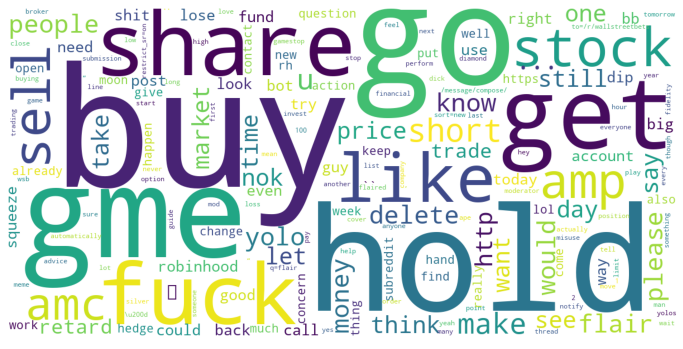

In [18]:
# WordCloud During Stage
show_wordcloud(d_tfidf)

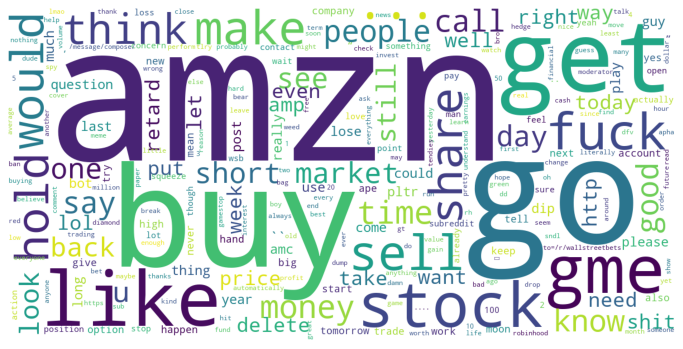

In [19]:
# WordCloud Post Stage
show_wordcloud(post_tfidf)

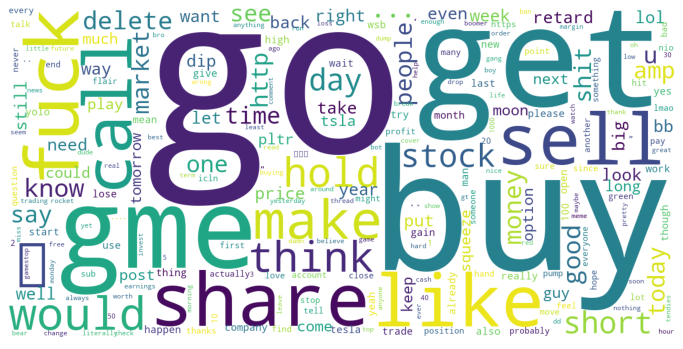

In [20]:
# WordCloud Pre Stage
show_wordcloud(pre_tfidf)